In [95]:
import tensorflow as tf
import keras
import numpy as np
import os
import matplotlib.pyplot as plt


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras import optimizers
from keras.callbacks import ModelCheckpoint ,EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input,GlobalAveragePooling2D,Flatten
from keras.utils import plot_model

In [96]:
datasetPath = './Avocado/'

In [97]:
ripe_train_path = datasetPath+'train/Ripe/'
unripe_train_path = datasetPath+'train/Unripe/'
ripe_validation_path = datasetPath+'validation/Ripe/'
unripe_validation_path = datasetPath+'validation/Unripe/'
ripe_test_path = datasetPath+'test/Ripe/'
unripe_test_path = datasetPath+'test/Unripe/'

## Construct data

In [64]:
ripe_train = []
for root, subdirs, files in os.walk(ripe_train_path):
    for elem in files:
        img = tf.keras.preprocessing.image.load_img(ripe_train_path+elem, target_size=(224, 224))
        new_img = np.array(img, dtype=np.float64)/255.0
        ripe_train.append(np.expand_dims(new_img, axis=0))
unripe_train = []
for root, subdirs, files in os.walk(unripe_train_path):
    for elem in files:
        img = tf.keras.preprocessing.image.load_img(unripe_train_path+elem, target_size=(224, 224))
        new_img = np.array(img, dtype=np.float64)/255.0
        unripe_train.append(np.expand_dims(new_img, axis=0))
#######################
ripe_truth = [0 for i in range(0, len(ripe_train))]
unripe_truth = [0 for i in range(0, len(unripe_train))]
#######################

data_train = []
data_train.append(ripe_train)
data_train.append(unripe_train)
data_train = [val for sublist in data_train for val in sublist]

all_y_truth = []
all_y_truth.append(ripe_truth)
all_y_truth.append(unripe_truth)
all_y_truth = [val for sublist in all_y_truth for val in sublist]

## split train and test
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(data_train,all_y_truth,test_size=0.2)
validation_data = zip(xtest, ytest)

In [98]:
train_path_dir = os.path.join(datasetPath, 'train')
val_path_dir = os.path.join(datasetPath, 'validation')
test_path_dir = os.path.join(datasetPath, 'test')

#train_path_dir = "/content/data/Avocado/Training"
#val_path_dir = "/content/data/Avocado/Validation"
#491 + 427

img_size = (224, 224)
batchsize = 16 


#### Train #####
train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest') 
train_generator = train_datagen.flow_from_directory(train_path_dir,
                                                  target_size=img_size,
                                                  color_mode='rgb',
                                                  batch_size=batchsize,
                                                  class_mode='binary',
                                                  shuffle=True)




#### Validation #####
val_datagen = ImageDataGenerator(rescale=1. / 255)
val_generator = val_datagen.flow_from_directory(val_path_dir,
                                                target_size=img_size,
                                                color_mode='rgb',
                                                batch_size=batchsize,
                                                class_mode='binary',
                                                shuffle=True)




#### Test #####
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = val_datagen.flow_from_directory(test_path_dir,
                                                target_size=img_size,
                                                color_mode='rgb',
                                                batch_size=batchsize,
                                                class_mode='binary',
                                                shuffle=True)

Found 748 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 309 images belonging to 2 classes.


In [103]:
# Load VGG16 Model, where it's Fully Connected Layers (top layer) is removed
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)
x = base_model.output

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(x)
# Add a fully connected layer
x = Dense(512, activation='relu')(x)

# Tried adam previously, but I think sigmoid is better for binary
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [104]:
sgd = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss="binary_crossentropy",metrics=["accuracy"])

# Checkpoints to stop model if validation loss is not decreasing
ModelCheckpointcheckpoint = ModelCheckpoint("best_model.h5",monitor='val_loss',mode='min',save_best_only=True,verbose=1)
EarlyStoppingearlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10,verbose = 1,restore_best_weights = True)
reducelr=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
callbacks=[ModelCheckpointcheckpoint,EarlyStoppingearlystop,reducelr]

In [105]:
import sys
from PIL import Image
sys.modules['Image'] = Image 
from PIL import Image
import Image

In [107]:

'''Training the model'''

total_epochs=50
train_steps = train_generator.n//train_generator.batch_size
val_steps    = val_generator.n//val_generator.batch_size


model.fit_generator(train_generator,
                    steps_per_epoch = train_steps,
                    epochs=total_epochs,
                    validation_data = val_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks)


Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5287
Epoch 00001: val_loss improved from inf to 0.70808, saving model to best_model.h5
46/46 [==============================] - 162s 4s/step - loss: 0.6857 - accuracy: 0.5287 - val_loss: 0.7081 - val_accuracy: 0.5000
Epoch 2/50
46/46 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.6325
Epoch 00002: val_loss improved from 0.70808 to 0.66511, saving model to best_model.h5
46/46 [==============================] - 149s 3s/step - loss: 0.6527 - accuracy: 0.6325 - val_loss: 0.6651 - val_accuracy: 0.5938
Epoch 3/50
46/46 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.7008
Epoch 00003: val_loss improved from 0.66511 to 0.64524, saving model to best_model.h5
46/46 [==============================] - 143s 3s/step - loss: 0.6378 - accuracy: 0.7008 - val_loss: 0.6452 - val_accuracy: 0.5750
Epoch 4/50
46/46 [==============================] - ETA: 0s - loss: 0.6035

Epoch 28/50
46/46 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.9590
Epoch 00028: val_loss improved from 0.35801 to 0.34955, saving model to best_model.h5
46/46 [==============================] - 136s 3s/step - loss: 0.3735 - accuracy: 0.9590 - val_loss: 0.3495 - val_accuracy: 0.9875
Epoch 29/50
46/46 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.9604
Epoch 00029: val_loss did not improve from 0.34955
46/46 [==============================] - 133s 3s/step - loss: 0.3631 - accuracy: 0.9604 - val_loss: 0.3502 - val_accuracy: 0.9812
Epoch 30/50
46/46 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.9536
Epoch 00030: val_loss improved from 0.34955 to 0.33224, saving model to best_model.h5
46/46 [==============================] - 133s 3s/step - loss: 0.3587 - accuracy: 0.9536 - val_loss: 0.3322 - val_accuracy: 0.9937
Epoch 31/50
46/46 [==============================] - ETA: 0s - loss: 0.3520 - accuracy: 0.9617
Epoch 0

In [106]:
'''total_epochs=50
model.fit(xtrain, 
          ytrain, 
          epochs=total_epochs,
          validation_data = np.array(list(validation_data)),
          callbacks=callbacks)
'''

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

In [108]:
export_path = "./Models/SavedModel/"
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = ./Models/SavedModel/

INFO:tensorflow:Assets written to: ./Models/SavedModel/assets


In [109]:
model_path = "./Models/SavedModel/"
model = tf.keras.models.load_model(model_path)

## Do ripe prediction

In [110]:
ripe_prediction = []

for root, subdirs, files in os.walk(ripe_test_path):
    for elem in files:
        img = tf.keras.preprocessing.image.load_img(ripe_test_path+elem, target_size=(224, 224))
        new_img = np.array(img, dtype=np.float64)/255.0
        image = np.expand_dims(new_img, axis=0) 
        ripe_prediction.append(0 if model.predict(image) <0.5 else 1)
ripe_truth = [0 for i in range(0, len(ripe_prediction))]

## Do unripe prediction

In [111]:
unripe_prediction = []

for root, subdirs, files in os.walk(unripe_test_path):
    for elem in files:
        img = tf.keras.preprocessing.image.load_img(unripe_test_path+elem, target_size=(224, 224))
        new_img = np.array(img, dtype=np.float64)/255.0
        image = np.expand_dims(new_img, axis=0) 
        unripe_prediction.append(0 if model.predict(image) <0.5 else 1)
unripe_truth = [1 for i in range(0, len(unripe_prediction))]

In [112]:
import seaborn as sns
labels=["ripe","unripe"]
def drow_confusion_matrix(y,ypred, labels):
    matrix=confusion_matrix(y,ypred)
    plt.figure(figsize=(15,10))
    colors=["indianred","lightseagreen"]
    sns.heatmap(matrix,xticklabels=labels,yticklabels=labels,cmap=colors,annot=True,fmt="d")
    plt.title("confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel("Predicted")
    plt.show()

## ripe test

precision_score : 1.0
accuracy_score : 1.0
recall_score : 1.0
True_positive : 0, False_positive : 0, True_negative : 166, False_negative : 0


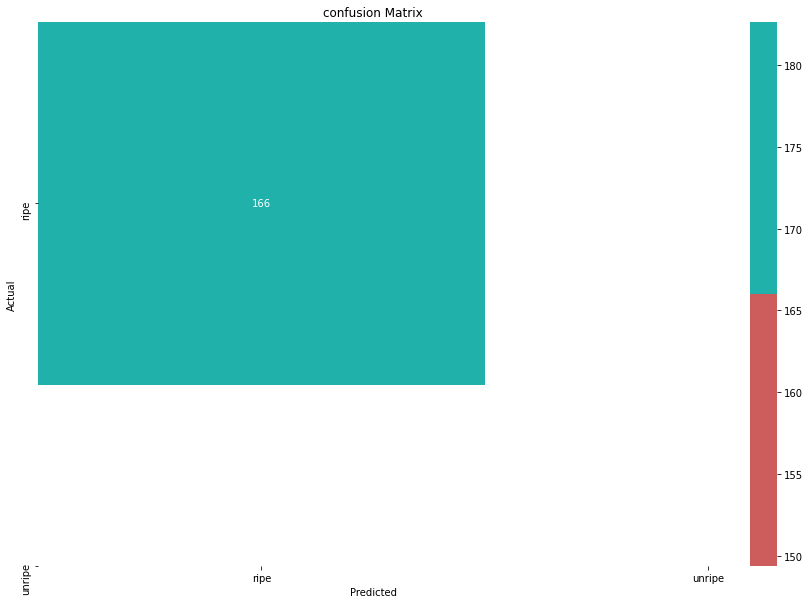

In [121]:
ytest = ripe_truth
y_pred = ripe_prediction
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))

tn, fp, fn, tp = confusion_matrix(ytest, y_pred, labels=[0,1]).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))
drow_confusion_matrix(ytest,y_pred, labels)

## unripe test

precision_score : 1.0
accuracy_score : 0.993006993006993
recall_score : 0.993006993006993
True_positive : 142, False_positive : 0, True_negative : 0, False_negative : 1


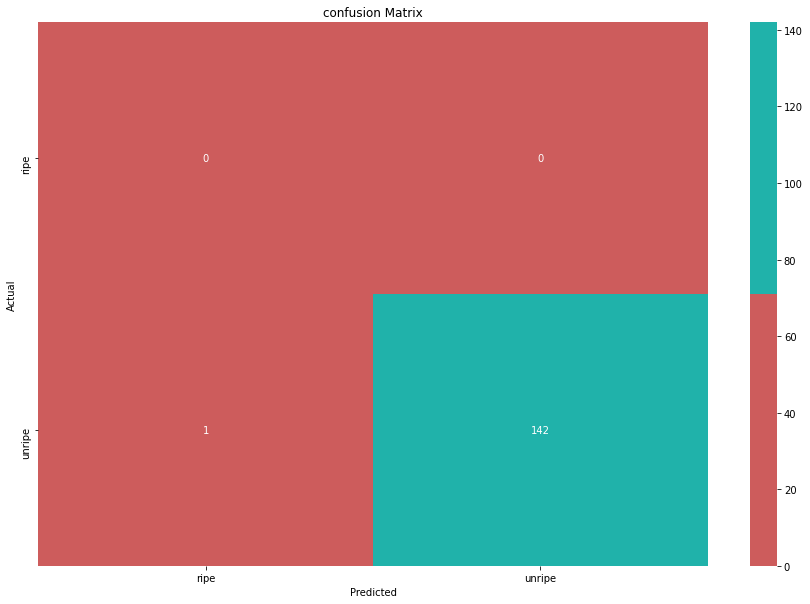

In [119]:
ytest = unripe_truth
y_pred = unripe_prediction
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))
drow_confusion_matrix(ytest,y_pred, labels)                                                                                                                      